In [1]:
%load_ext autoreload
%autoreload 2

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib inline
fig_width_pt = 525  # Get this from LaTeX using \showthe\columnwidth
fig_width_pt = 618  # Get this from LaTeX using \showthe\columnwidth
fig_width_pt = 1024  # Get this from LaTeX using \showthe\columnwidth
ppi = 72.27 # (constant) definition of the ppi = points per inch
inches_per_pt = 1.0/ppi  # Convert pt to inches
#inches_per_cm = 1./2.54
figwidth = fig_width_pt*inches_per_pt  # width in inches
phi = (np.sqrt(5) + 1. ) /2 # golden ratio is good for your eyes
dpi_export = 600

In [4]:
figname = '../paper/fig_result'

## Simple Fixation Map training (2 layers)
with clutter / whitening

In [5]:
verbose = True

In [6]:
import sys
sys.path.append('../figures')
from retina import MotionCloudNoise, vectorization, get_data_loader, minmax

In [7]:
N_theta = 6
N_azimuth = 16
N_eccentricity = 10
N_phase = 2

N_pic = 128
N_X = N_pic
N_Y = N_pic
rho = 1.41
verbose = 1


In [8]:
retina_transform = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)

In [9]:
# retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
# retina_inverse = np.linalg.pinv(retina_vector)

In [10]:
loader = get_data_loader(batch_size=100, train = False)

In [11]:
path = "../data/MNIST_accuracy.npy"
import os
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


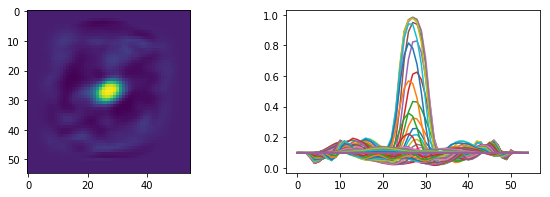

In [12]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(accuracy_map)
plt.subplot(122)
_ = plt.plot(accuracy_map)

In [13]:
from retina import do_offset, accuracy_fullfield

In [14]:
colliculus = (retina_transform**2).sum(axis=(0, 3))
#colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(16, 10, 16384)


In [15]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(160, 16384)


In [16]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(16384, 160)


### From MNIST encoding

In [17]:
from retina import place_object

# Hyperparameters

In [18]:
minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-4 #1e-3  #0.05

OFFSET_STD = 15 #
OFFSET_MAX = 30 #
NOISE = 1 #0 #
CONTRAST = 0.5 #1 #
sf_0 = 0.2
B_sf = 0.3

### Test

In [ ]:
from retina import retina, retina_inverse
retina_inverse_transform = retina_inverse(retina_transform)

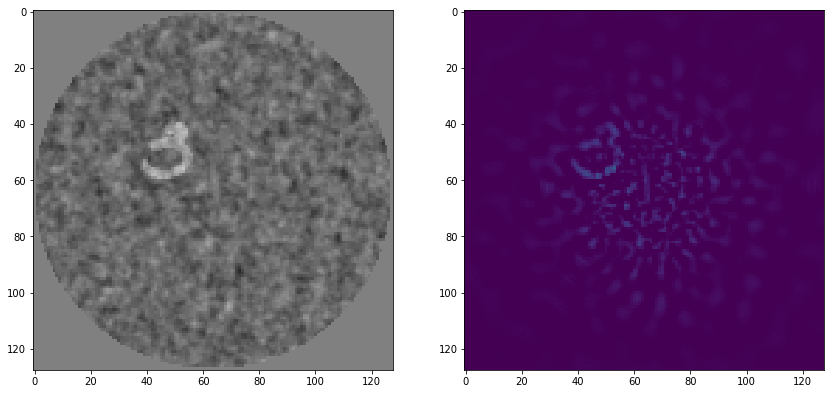

In [ ]:
data, label = next(iter(loader))
fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
i = 4
offset_std=OFFSET_STD
offset_max=OFFSET_MAX
i_offset = minmax(np.random.randn() * offset_std, offset_max)
j_offset = minmax(np.random.randn() * offset_std, offset_max)

data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset, 
                                CONTRAST=CONTRAST, NOISE=NOISE,
                                sf_0=sf_0, B_sf=B_sf)
data_retina, tensor_retina  =  retina(data_fullfield, retina_transform)

axs[0].imshow(data_fullfield, cmap=plt.gray(), vmin=0, vmax=1)
axs[1].imshow((retina_inverse_transform @ data_retina).reshape(N_pic, N_pic), vmin=0, vmax=1, cmap=plt.viridis())


#### Orientation invariant power encoding (colliculus??)

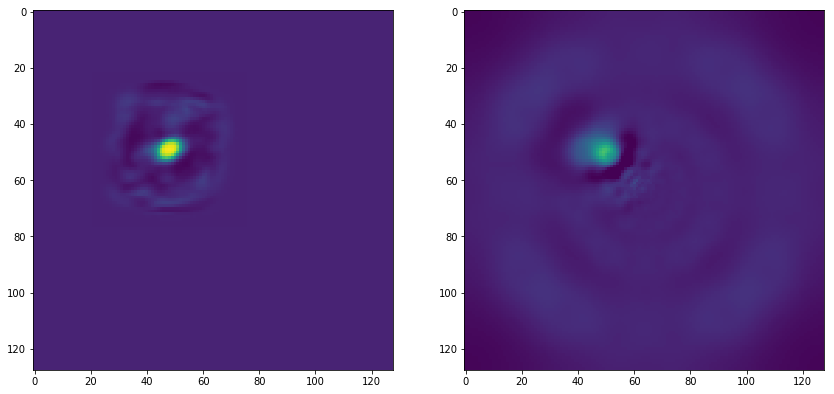

In [ ]:

accuracy_fullfield_map = do_offset(accuracy_map, i_offset, j_offset, N_pic=N_pic, min=0.1)
accuracy_colliculus = colliculus_vector @ accuracy_fullfield_map.ravel()
im = colliculus_inverse @ accuracy_colliculus

fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0].imshow(accuracy_fullfield_map, vmin=0, vmax=1)
axs[1].imshow(im.reshape(N_pic, N_pic), vmin=0, vmax=1, cmap=plt.viridis())



#### Torch stuff

In [ ]:
import torch
do_cuda = False # torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.device("cuda" if do_cuda else "cpu")

In [ ]:
train_loader = get_data_loader(batch_size=minibatch_size, train = True)
test_loader = get_data_loader(batch_size=1000, train = False)

# Network

In [ ]:
# FIC_NAME = "2019-02-15-anywhere-additive-noise-white-1000-Necc-10"
# FIC_NAME = "2019-03-02-anywhere-background-noise-white-1000"
FIC_NAME = "../data/2019-03-07_CNS"
FIC_NAME = "../data/2019-03-08_CNS"


In [ ]:
BIAS_CONV = True
BIAS_DECONV = True #True

class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 200, bias = BIAS_DECONV)
        self.bn1= torch.nn.Linear(N_theta*N_azimuth*N_eccentricity*N_phase, 1000, bias = BIAS_DECONV)
        #self.bn2 = torch.nn.Linear(200, 80, bias = BIAS_DECONV)
        self.bn2 = torch.nn.Linear(1000, 1000, bias = BIAS_DECONV)
        #self.bn3 = torch.nn.Linear(80, N_azimuth*N_eccentricity, bias = BIAS_DECONV)
        self.bn3 = torch.nn.Linear(1000, N_azimuth*N_eccentricity, bias = BIAS_DECONV)
                
    def forward(self, image):
       
        h_bn1 = F.relu(self.bn1(image))               
        h_bn2 = F.relu(self.bn2(h_bn1))
        h_bn2_drop = F.dropout(h_bn2, p = .5) 
        u = self.bn3(h_bn2_drop)
        
        return u


In [ ]:
net = Net()

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [ ]:
loss_func = torch.nn.BCEWithLogitsLoss() #torch.nn.CrossEntropyLoss()

#### Training

In [ ]:
import time
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
def accuracy_gain(prediction, fixmap_data, batch_size, full_fixmap = None):
    #ndices_max = np.zeros(batch_size, dtype = 'int')
    acc = [] #np.zeros(batch_size)
    
    for i in range(batch_size):
        fixmap_coll =  fixmap_data[i,:].data.numpy()
        pred_coll = F.sigmoid(prediction[i,:]).data.numpy()
        
        indice_max_coll = np.where(pred_coll == max(pred_coll))[0][0]
        acc_coll = fixmap_coll[indice_max_coll]
        
        '''masque = 0.1 + np.zeros(fixmap_coll.shape)
        masque[indice_max_coll] = 1'''
        
        test = pred_coll.reshape((N_azimuth, N_eccentricity))
        indices_ij = np.where(test == max(test.flatten()))
        azimuth = indices_ij[0][0]
        eccentricity = indices_ij[1][0]
        full_masque = colliculus[azimuth,eccentricity,:] #> 0.0003
        
        
        #print(indices_ij)
        '''j_max = indices_ij[1][0]
        if j_max > 1:
            test[:,:int(j_max*2/3)] = 0.1 
        pred_coll_test = test.flatten()'''
        
        if full_fixmap is not None:
            full_ref = full_fixmap[i,:]
            #print('OK')
        else:
            full_ref = colliculus_inverse @ fixmap_coll.flatten()
            
        full_pred = colliculus_inverse @ pred_coll.flatten()
        #full_masque = colliculus_inverse @ masque.flatten()
        #masque[np.where(masque < 0.11)] = 0
#        full_pred *= full_masque
        full_pred = full_masque
        #full_pred = colliculus_inverse @ pred_coll_test.flatten()
        
        indice_max_full = np.where(full_pred == max(full_pred))[0][0]
        #print(indice_max_full)
        acc_full = full_ref[indice_max_full] 
                
        #acc[i] = max(acc_full, acc_coll)
        if acc_full > acc_coll:
            acc += [acc_full]
            
        #acc[i] = 0.1 + (acc[i] - 0.1) * 2.25
    #print(indices_max)
    if len(acc) > 0:
        acc_mean = np.mean(acc) #fixmap_data.data.numpy()[:,indices_max])
    else:
        acc_mean = acc_coll
    #acc = np.mean(fixmap_data[:,indices_max])
    return acc_mean, acc

In [ ]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = 1, \
          offset_std=OFFSET_STD, \
          offset_max=OFFSET_MAX, \
          verbose=1, \
          CONTRAST=CONTRAST,
          NOISE = NOISE,
          sf_0 = sf_0, 
          B_sf = B_sf):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        retina_data = np.zeros((minibatch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
        fixmap_data = np.zeros((minibatch_size, N_azimuth * N_eccentricity))

        for i in range(minibatch_size):
            i_offset = minmax(np.random.randn() * offset_std, offset_max)
            j_offset = minmax(np.random.randn() * offset_std, offset_max)
            
            data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset, 
                                            CONTRAST=CONTRAST, NOISE=NOISE,
                                            sf_0=sf_0, B_sf=B_sf)
            retina_data[i, :], _  =  retina(data_fullfield, retina_transform)

            fixmap_data[i,:] = accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic, colliculus_vector)
            
        retina_data = Variable(torch.FloatTensor(retina_data))
        fixmap_data = Variable(torch.FloatTensor(fixmap_data))
        
        prediction = net(retina_data)
        loss = loss_func(prediction, fixmap_data)
        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            #indices_max = np.zeros(minibatch_size, dtype = 'int')
            #for i in range(minibatch_size):
            #    indices_max[i] = np.where(prediction[i,:] == max(prediction[i,:]))[0][0]
            #acc = np.mean(fixmap_data.data.numpy()[:,indices_max])
            acc, _ = accuracy_gain(prediction, fixmap_data, minibatch_size)
            print('[%d/%d] Loss: %.3f Acc : %.3f'%(batch_idx*minibatch_size, len(train_loader.dataset),loss.data.numpy(), acc))
            f = open(FIC_NAME.replace('npy', 'txt'), 'a')
            f.write('%.5f\t%.5f'%(loss, acc))    
            f.close()
    return net


In [ ]:
def test(net, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity, offset_std=OFFSET_STD, offset_max=OFFSET_MAX, 
         CONTRAST=CONTRAST, NOISE = NOISE,
         sf_0 = sf_0, 
         B_sf = B_sf):
    #for batch_idx, (data, label) in enumerate(test_loader):
    data, label = next(iter(test_loader))
    batch_size = label.shape[0]

    retina_data = np.zeros((batch_size, N_phase * N_theta * N_azimuth * N_eccentricity))
    fixmap_data = np.zeros((batch_size, N_azimuth * N_eccentricity))

    for i in range(batch_size):
        i_offset = minmax(np.random.randn() * offset_std, offset_max)
        j_offset = minmax(np.random.randn() * offset_std, offset_max)
        data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset, 
                                        CONTRAST=CONTRAST, NOISE=NOISE,
                                        sf_0=sf_0, B_sf=B_sf)
        retina_data[i, :], _  =  retina(data_fullfield, retina_transform)

        #accuracy_fullfield = do_offset(accuracy_map, i_offset, j_offset, N_pic=128, min=0.1)
        fixmap_data[i,:] = accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic, colliculus_vector)
        #colliculus_vector @ accuracy_fullfield.ravel()

    retina_data = Variable(torch.FloatTensor(retina_data))
    fixmap_data = Variable(torch.FloatTensor(fixmap_data))
    
    with torch.no_grad():
        output = net(retina_data) #.data.numpy()
        #indices_max = np.zeros(batch_size, dtype = 'int')
        #for i in range(batch_size):
        #    indices_max[i] = np.where(output[i,:] == max(output[i,:]))[0][0]
        #acc = np.mean(fixmap_data.data.numpy()[:,indices_max])
        #acc = 0.1 + (acc - 0.1) * 2.5
        acc, _ = accuracy_gain(output, fixmap_data, batch_size)

    return acc


## Anywhere target, with noise

#### Additive noise + whitening

In [ ]:
if not os.path.isfile(FIC_NAME + '.npy'):
    for epoch in range(10):
        train(net, minibatch_size)
        loss = test(net)
        print('Test set: Final Loss: %.3f'%loss) 
    torch.save(net, FIC_NAME + '.npy')
else:
    net = torch.load(FIC_NAME + '.npy')       

Starting training...
[0/60000] Loss: 0.693 Acc : 0.142
[1000/60000] Loss: 0.627 Acc : 0.174
[2000/60000] Loss: 0.495 Acc : 0.127
[3000/60000] Loss: 0.379 Acc : 0.147
[4000/60000] Loss: 0.390 Acc : 0.178
[5000/60000] Loss: 0.383 Acc : 0.172
[6000/60000] Loss: 0.382 Acc : 0.244
[7000/60000] Loss: 0.369 Acc : 0.160
[8000/60000] Loss: 0.358 Acc : 0.167
[9000/60000] Loss: 0.367 Acc : 0.194
[10000/60000] Loss: 0.368 Acc : 0.174
[11000/60000] Loss: 0.368 Acc : 0.134
[12000/60000] Loss: 0.360 Acc : 0.181
[13000/60000] Loss: 0.374 Acc : 0.141
[14000/60000] Loss: 0.365 Acc : 0.174
[15000/60000] Loss: 0.364 Acc : 0.173
[16000/60000] Loss: 0.359 Acc : 0.172
[17000/60000] Loss: 0.368 Acc : 0.212
[18000/60000] Loss: 0.369 Acc : 0.262
[19000/60000] Loss: 0.359 Acc : 0.216
[20000/60000] Loss: 0.359 Acc : 0.148
[21000/60000] Loss: 0.369 Acc : 0.255
[22000/60000] Loss: 0.366 Acc : 0.182
[23000/60000] Loss: 0.362 Acc : 0.201
[24000/60000] Loss: 0.362 Acc : 0.168
[25000/60000] Loss: 0.371 Acc : 0.204
[260

# Visualisation

In [ ]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

test_batch_size = 20
test_loader = get_data_loader(batch_size=test_batch_size, train = False)

data, label = next(iter(test_loader))
input_n = np.zeros((test_batch_size, 1, vsize))
a_data_n = np.zeros((test_batch_size, 1, asize))
full_fixmap_n = np.zeros((test_batch_size, 128, 128))
        # target = np.zeros((minibatch_size, asize))

for idx in range(test_batch_size):
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    
    data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset, 
                                    CONTRAST=CONTRAST, NOISE=NOISE,
                                    sf_0=sf_0, B_sf=B_sf)
    input_n[idx, 0, :], _  =  retina(data_fullfield, retina_transform)

    a_data_n[idx, 0, :] = accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic, colliculus_vector)
    #full_fixmap_n[idx, :, :] = 

In [ ]:
delta = 1/N_azimuth
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))
for idx in range(test_batch_size):
    im = retina_inverse_transform @ input_n[idx,0,:]
    plt.figure(figsize = (15, 5))
    plt.subplot(161)
    plt.plot(input_n[idx,0,:])
    plt.subplot(162)
    plt.imshow(im.reshape(128, 128))
    plt.plot(63.5, 63.5, 'r+')
    plt.title(idx)
    plt.subplot(163)
    plt.plot(a_data_n[idx,0,:])    
    col = colliculus_inverse @ a_data_n[idx,0,:]
    ax = plt.subplot(164, projection='polar')
    vec_t = Variable(torch.FloatTensor(a_data_n[idx,0,:]))
    vec_t = vec_t.reshape((1,N_azimuth * N_eccentricity))
    ax.pcolor(theta, log_r, vec_t.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(col.reshape(128, 128))
    in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
    out_t = net(in_t)
    out_sig = F.sigmoid(out_t).detach().numpy()
    out_t = out_t.reshape((1,N_azimuth * N_eccentricity))
    #acc, _ = accuracy_gain(out_t.reshape(1,N_azimuth * N_eccentricity), vec_t.reshape(1,N_azimuth * N_eccentricity), 1)
    acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
    plt.subplot(165)
    plt.plot(out_sig)    
    plt.title(acc)
    view = colliculus_inverse @ out_sig.flatten()
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(view.reshape(128, 128))
                                 

In [ ]:
if False:
    i = 0
    offset_std=OFFSET_STD
    offset_max=OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
            
    data_fullfield = place_object(data[i, 0, :, :].numpy(), i_offset, j_offset, 
                                    CONTRAST=CONTRAST, NOISE=NOISE,
                                    sf_0=sf_0, B_sf=B_sf)
    input_vector, _  =  retina(data_fullfield, retina_transform)

    coll_fixmap = accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic, colliculus_vector)

    #plt.imshow(input_test)
    in_ = Variable(torch.FloatTensor(input_vector))
    out = net(in_)
    
    plt.figure(figsize = (20,6))

    plt.subplot(151)
    plt.imshow(image)

    plt.subplot(152)
    f = plt.plot(coll_fixmap)
    f = plt.plot(F.sigmoid(out.data))

    plt.subplot(153)
    im = colliculus_inverse @ coll_fixmap
    plt.imshow(im.reshape(128, 128))
    print(max(coll_fixmap))
    print(max(im))

    plt.subplot(154)
    im_pred = colliculus_inverse @ F.sigmoid(out).data.numpy().flatten()
    plt.imshow(im_pred.reshape(128, 128))
    ind_pred = np.where(im_pred == max(im_pred))
    print(im[ind_pred])

    plt.subplot(155)
    test = F.sigmoid(out).data.numpy().reshape((N_azimuth, N_eccentricity))
    indices_ij = np.where(test == max(test.flatten()))
    azimuth = indices_ij[0][0]
    eccentricity = indices_ij[1][0]
    full_masque = colliculus[azimuth,eccentricity,:].reshape(128, 128)
    plt.imshow(im_pred.reshape(128, 128) * full_masque)
    


In [ ]:
vsize = N_theta * N_azimuth * N_eccentricity * N_phase
asize = N_azimuth * N_eccentricity
offset_std=OFFSET_STD
offset_max=OFFSET_MAX

test_batch_size = 1000

mem_acc_log = []
mem_acc_data_log = []
mem_ref_log = []
mem_ref_data_log = []

ecc_max=.8

for i_eccentricity in range(9):
    ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc
    print(r)

    test_loader_2 = get_data_loader(batch_size=test_batch_size, train = False)

    data, label = next(iter(test_loader_2))
    input_n = np.zeros((test_batch_size, 1, vsize))
    a_data = np.zeros((test_batch_size, asize))
    full_fixmap_n = np.zeros((test_batch_size, 128 * 128))
    # target = np.zeros((minibatch_size, asize))
        
    ref_data = np.zeros(test_batch_size)

    for idx in range(test_batch_size):
        theta = np.random.rand() * 2 * np.pi
        i_offset = int(r * np.cos(theta))
        j_offset = int(r * np.sin(theta))
        #i_offset = i #minmax(np.random.randn() * offset_std, offset_max)
        #j_offset = 0 #minmax(np.random.randn() * offset_std, offset_max)
        
        data_fullfield = place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset, 
                                        CONTRAST=CONTRAST, NOISE=NOISE,
                                        sf_0=sf_0, B_sf=B_sf)
        input_n[idx, 0, :], _  =  retina(data_fullfield, retina_transform)

        a_data[idx, :] = accuracy_fullfield(accuracy_map, i_offset, j_offset, N_pic, colliculus_vector)
        tmp = colliculus_inverse @ accuracy_colliculus

        full_fixmap_n[idx,:] = tmp.flatten()
        if r < 28:
            ref_data[idx] = accuracy_map[27 + i_offset, 27 + j_offset]
        else:
            ref_data[idx] = 0.1        
        
        
    in_t = Variable(torch.FloatTensor(input_n))
    out_t = net(in_t)
    a_data_t = Variable(torch.FloatTensor(a_data))
    #out_sig = F.sigmoid(out).detach().numpy()
    acc, acc_data = accuracy_gain(out_t, a_data_t, test_batch_size, full_fixmap=full_fixmap_n)
    mem_acc_log += [acc]
    mem_acc_data_log += [acc_data]
    
    mem_ref_log += [np.mean(ref_data)]
    

In [ ]:
theta, log_r, vec_t

In [ ]:
idx = 3
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))

fig = plt.figure(figsize = (21,6))
ax_A = plt.subplot(1,8,(1,2))
im = retina_inverse_transform @ input_n[idx,0,:]
ax_A.imshow(im.reshape(128, 128))
ax_A.plot(64.5, 64.5, 'r+', markersize = 14, mew=3)
ax_A.axis('off')
ax_A.set_title('Input', fontsize = 14)

ax_B = plt.subplot(2,8,3, projection='polar')
vec_t = Variable(torch.FloatTensor(a_data_n[idx,0,:]))
vec_t = vec_t.reshape((1,N_azimuth * N_eccentricity))
ax_B.pcolor(theta, log_r, vec_t.reshape((N_azimuth, N_eccentricity)))
ax_B.grid('off')
#ax.set_rgrids('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2,8,11, projection='polar')
in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
out_t = net(in_t)
out_sig = F.sigmoid(out_t).detach().numpy()
ax_Bb.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])

test = out_sig.reshape((N_azimuth, N_eccentricity))
indices_ij = np.where(test == max(test.flatten()))
azimuth = indices_ij[0][0]
eccentricity = indices_ij[1][0]
full_masque = colliculus[azimuth,eccentricity,:]
indice_move = np.where(full_masque == max(full_masque))
i_move = indice_move[0][0] // 128 - 64
j_move = indice_move[0][0] % 128 - 64
print(i_move, j_move)

ax_C = plt.subplot(1,8,(4,5))
im = retina_inverse_transform @ input_n[idx,0,:]
ax_C.imshow(im.reshape(128, 128))
ax_C.plot(64.5, 64.5, 'r+', markersize = 14, mew=3)
ax_C.arrow(64.5, 64.5, j_move, i_move, color = 'red', linewidth = 3, head_width=3, head_length=3)

plt.axis('off')
vec_t = vec_t.reshape((1,N_azimuth * N_eccentricity))
out_t = out_t.reshape((1,N_azimuth * N_eccentricity))
acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
ax_C.set_title('Final accuracy : ' + str(acc), fontsize = 14)

ax_D = plt.subplot(1,32,(23, 32))
ax_D.bar(range(1,10), mem_acc_log, alpha = .5, label = 'One saccade')
ax_D.bar(range(1,10), mem_ref_log, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
ax_D.plot([0.5,9.5], [0.1, 0.1], ':', label = 'Baseline')
plt.legend()
ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (scale)', fontsize = 12)
ax_D.set_xticks(range(1,10))
ax_D.set_ylim([0,1])

x_offset = -.15
# y_offset = 1.2
for ax, text, x, y_offset in [[ax_A, 'A', offset, 1.2], [ax_B, 'B', offset, 1.3], [ax_C, 'C', offset, 1.2], [ax_D, 'D', offset, 1.1]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=32,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 


#plt.savefig(figname + '.pdf')


In [ ]:
std_data_log = np.zeros(9)
for i in range(9):
    std_data_log[i] = np.std(mem_acc_data_log[i])

In [ ]:
mem_acc_data_log[8]

In [ ]:
plt.fill_between(range(1,10), mem_acc_log + std_data_log, mem_acc_log - std_data_log, alpha = .3)
plt.plot(range(1,10), mem_acc_log)
plt.plot(range(1,10), mem_ref_log) #accuracy_map[27,27:55])

In [ ]:
plt.bar(range(1,10), mem_ref_log, alpha = .5) #accuracy_map[27,27:55])

f = plt.boxplot(mem_acc_data_log, showfliers=False)
#f = plt.plot(range(1,10), mem__log) #accuracy_map[27,27:55])



In [ ]:
mem_acc

In [ ]:
mem_acc

In [ ]:
'''im_coll = colliculus[0,0,:].reshape((128,128)) +\
        colliculus[1,0,:].reshape((128,128)) +\
        colliculus[2,0,:].reshape((128,128)) +\
        colliculus[3,0,:].reshape((128,128)) +\
        colliculus[4,0,:].reshape((128,128)) +\
        colliculus[5,0,:].reshape((128,128)) +\
        colliculus[6,0,:].reshape((128,128)) +\
        colliculus[7,0,:].reshape((128,128))'''
im_coll = colliculus[4,0,:].reshape((128,128))
plt.imshow(im_coll)
plt.figure()
f = plt.plot(im_coll)
print(sum(im_coll.flatten()))
f = plt.plot(np.arange(0,55) - 27 + 64, accuracy_map[:,:])

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
im = np.copy(-30 * colliculus[3,0,:].reshape((128,128))) 
b_inf = 64 - 27
im[b_inf:b_inf+55,b_inf:b_inf+55] += accuracy_map
plt.imshow(im)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
f = plt.plot(im[63,:])
plt.plot(range(64-27, 64-27 + 55) , accuracy_map[27,:])
im2 = colliculus[3,0,:].reshape((128,128))
plt.plot(im2[63,:] * 30)

In [ ]:
im_sum = colliculus[0,0,:].reshape((128,128)) +\
           colliculus[0,1,:].reshape((128,128)) +\
           colliculus[0,3,:].reshape((128,128)) +\
           colliculus[0,4,:].reshape((128,128)) +\
           colliculus[0,5,:].reshape((128,128)) +\
           colliculus[0,6,:].reshape((128,128)) +\
           colliculus[0,7,:].reshape((128,128)) +\
           colliculus[0,8,:].reshape((128,128))
f = plt.plot(im_sum)

In [ ]:
plt.imshow(colliculus[0,5,:].reshape(128,128) > 0.0003)

In [ ]:
accuracy_map.shape